In [8]:
from symred.symplectic_form import PauliwordOp, StabilizerOp, AnsatzOp, ObservableOp, QuantumState
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
import json
import numpy as np
from openfermion import FermionOperator
from scipy.sparse.linalg import expm
from openfermion import get_sparse_operator
from pyscf.cc.addons import spatial2spin


import warnings
warnings.filterwarnings("ignore")

In [9]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

# Build the molecule

In [66]:
# Set molecule parameters
speciesname = 'CO2_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
geometry = [('N', [0.0, 0.0, 1000000]), ('N', [0.0, 0.0, -1000000])]

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))

print(xyz_file)
xyz_file

carbon dioxide
3
 
N	0.0	0.0	1000000
N	0.0	0.0	-1000000


'3\n \nN\t0.0\t0.0\t1000000\nN\t0.0\t0.0\t-1000000'

In [67]:
from symred.chem import PySCFDriver

convergence = 1e6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

In [68]:
pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
print('FCI converged? ', pyscf_obj.pyscf_fci.converged)

hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot
fci_energy = pyscf_obj.pyscf_fci.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -101.06620409535041
MP2 energy: -101.1184302981165
CCSD energy: -101.13030317685798
FCI energy: -107.43802032518788


In [69]:
from symred.chem import FermionicHamilt
import openfermion as of

H_ferm = FermionicHamilt(pyscf_obj.pyscf_hf)
H_ferm.build_operator()
n_qubits = H_ferm.n_qubits
print('Number of qubits:', n_qubits)

Number of qubits: 20


In [70]:
ham_fermionic = of.get_fermion_operator(H_ferm.fermionic_molecular_hamiltonian)
ham_jw = of.jordan_wigner(ham_fermionic)

In [71]:
def QubitOperator_to_dict(op, num_qubits):
    assert(type(op) == of.QubitOperator)
    op_dict = {}
    term_dict = op.terms
    terms = list(term_dict.keys())

    for t in terms:    
        letters = ['I' for i in range(num_qubits)]
        for i in t:
            letters[i[0]] = i[1]
        p_string = ''.join(letters)        
        op_dict[p_string] = term_dict[t]
         
    return op_dict

ham_dict = QubitOperator_to_dict(ham_jw, n_qubits)
ham = ObservableOp({op:coeff for op,coeff in ham_dict.items() if coeff.imag==0})

print('Jordan-Wigner Hamiltonian:\n\n', ham)

Jordan-Wigner Hamiltonian:

 -69.5436273670 IIIIIIIIIIIIIIIIIIII +
9.1574663150 ZIIIIIIIIIIIIIIIIIII +
0.0642286934 YZZZYIIIIIIIIIIIIIII +
0.0642286934 XZZZXIIIIIIIIIIIIIII +
9.1574663150 IZIIIIIIIIIIIIIIIIII +
0.0642286934 IYZZZYIIIIIIIIIIIIII +
0.0642286934 IXZZZXIIIIIIIIIIIIII +
9.1549339552 IIZIIIIIIIIIIIIIIIII +
0.1568470280 IIYZZZZZZZZZYIIIIIII +
0.1568470280 IIXZZZZZZZZZXIIIIIII +
9.1549339552 IIIZIIIIIIIIIIIIIIII +
0.1568470280 IIIYZZZZZZZZZYIIIIII +
0.1568470280 IIIXZZZZZZZZZXIIIIII +
1.0693272184 IIIIZIIIIIIIIIIIIIII +
1.0693272184 IIIIIZIIIIIIIIIIIIII +
0.8156236639 IIIIIIZIIIIIIIIIIIII +
0.8156236639 IIIIIIIZIIIIIIIIIIII +
0.8156236639 IIIIIIIIZIIIIIIIIIII +
0.8156236639 IIIIIIIIIZIIIIIIIIII +
0.8156236639 IIIIIIIIIIZIIIIIIIII +
0.8156236639 IIIIIIIIIIIZIIIIIIII +
1.0718595782 IIIIIIIIIIIIZIIIIIII +
1.0718595782 IIIIIIIIIIIIIZIIIIII +
0.8156236639 IIIIIIIIIIIIIIZIIIII +
0.8156236639 IIIIIIIIIIIIIIIZIIII +
0.8156236639 IIIIIIIIIIIIIIIIZIII +
0.8156236639 IIIIIIIIIIIIIIIIIZII

In [72]:
# singles

t1 = spatial2spin(pyscf_obj.pyscf_ccsd.t1)
no, nv = t1.shape
nmo = no + nv
ccsd_single_amps = np.zeros((nmo, nmo))
ccsd_single_amps[no:,:no] = t1.T

single_amplitudes_list = []
for i, j in zip(*ccsd_single_amps.nonzero()):
    single_amplitudes_list.append([[i, j], ccsd_single_amps[i, j]])

generator_t1 = FermionOperator()
for (i, j), t_ij in single_amplitudes_list:
    i, j = int(i), int(j)
    generator_t1 += FermionOperator(((i, 1), (j, 0)), t_ij)
    
T1_dict = QubitOperator_to_dict(of.jordan_wigner(generator_t1), n_qubits)
try:
    T1 = PauliwordOp(T1_dict)
    T1 -= T1.conjugate
    T1 = T1.cleanup_zeros()
    T1 = T1.multiply_by_constant(-1j)
    print('Single excitation terms:\n\n', T1)
except:
    print('No single excitations')

No single excitations


In [73]:
generator_t1 == FermionOperator()

True

In [74]:
# doubles!

t2 = spatial2spin(pyscf_obj.pyscf_ccsd.t2)
no, nv = t2.shape[1:3]
nmo = no + nv
double_amps = np.zeros((nmo, nmo, nmo, nmo))
double_amps[no:,:no,no:,:no] = .5 * t2.transpose(2,0,3,1)

double_amplitudes_list=[]
double_amplitudes = double_amps
for i, j, k, l in zip(*double_amplitudes.nonzero()):
    if not np.isclose(double_amplitudes[i, j, k, l], 0):
        double_amplitudes_list.append([[i, j, k, l],
                                       double_amplitudes[i, j, k, l]])
    
generator_t2 = FermionOperator()

# Add double excitations
for (i, j, k, l), t_ijkl in double_amplitudes_list:
    i, j, k, l = int(i), int(j), int(k), int(l)
    generator_t2 += FermionOperator(((i, 1), (j, 0), (k, 1), (l, 0)), t_ijkl)
#     if anti_hermitian:
#         generator += FermionOperator(((l, 1), (k, 0), (j, 1), (i, 0)),
#                                      -t_ijkl)

T2_dict = QubitOperator_to_dict(of.jordan_wigner(generator_t2), n_qubits)
T2 = PauliwordOp(T2_dict)
T2 -= T2.conjugate
T2 = T2.cleanup_zeros()
T2 = T2.multiply_by_constant(-1j)


print('Double excitation terms:\n\n', T2)

Double excitation terms:

 0.0354692937-0.0000000000j IIIIIIIIIIIIXXIIIIXY +
0.0354692937-0.0000000000j IIIIIIIIIIIIXXIIIIYX +
-0.0354692937+0.0000000000j IIIIIIIIIIIIXYIIIIXX +
0.0354692937-0.0000000000j IIIIIIIIIIIIXYIIIIYY +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYXIIIIXX +
0.0354692937-0.0000000000j IIIIIIIIIIIIYXIIIIYY +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYYIIIIXY +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYYIIIIYX +
0.0354692937-0.0000000000j IIIIIIIIIIIIXXIIXYII +
0.0354692937-0.0000000000j IIIIIIIIIIIIXXIIYXII +
-0.0354692937+0.0000000000j IIIIIIIIIIIIXYIIXXII +
0.0354692937-0.0000000000j IIIIIIIIIIIIXYIIYYII +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYXIIXXII +
0.0354692937-0.0000000000j IIIIIIIIIIIIYXIIYYII +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYYIIXYII +
-0.0354692937+0.0000000000j IIIIIIIIIIIIYYIIYXII +
0.0354692937-0.0000000000j IIIIIIIIIIIIXXXYIIII +
0.0354692937-0.0000000000j IIIIIIIIIIIIXXYXIIII +
-0.0354692937+0.0000000000j IIIIIIIIIIIIXYXXIIII +
0.0354692937-0

In [75]:
T = generator_t1 + 0.5 * generator_t2

In [76]:
try:
    T_antiherm = T1 + T2.multiply_by_constant(0.5)
except:
    T_antiherm = T2.multiply_by_constant(0.5)

T_antiherm = AnsatzOp(T_antiherm.symp_matrix, T_antiherm.coeff_vec)
print('UCCSD operator:\n\n', T_antiherm)

UCCSD operator:

 0.0000002439 IIIIIIIIIIIIIXZYIIII +
-0.0000002439 IIIIIIIIIIIIIYZXIIII +
0.0000002439 IIIIIIIIIIIIXZYIIIII +
-0.0000002439 IIIIIIIIIIIIYZXIIIII +
0.0177346469 IIIIIIIIIIIIXXIIIIXY +
0.0177346469 IIIIIIIIIIIIXXIIIIYX +
-0.0177346469 IIIIIIIIIIIIXYIIIIXX +
0.0177346469 IIIIIIIIIIIIXYIIIIYY +
-0.0177346469 IIIIIIIIIIIIYXIIIIXX +
0.0177346469 IIIIIIIIIIIIYXIIIIYY +
-0.0177346469 IIIIIIIIIIIIYYIIIIXY +
-0.0177346469 IIIIIIIIIIIIYYIIIIYX +
0.0177346469 IIIIIIIIIIIIXXIIXYII +
0.0177346469 IIIIIIIIIIIIXXIIYXII +
-0.0177346469 IIIIIIIIIIIIXYIIXXII +
0.0177346469 IIIIIIIIIIIIXYIIYYII +
-0.0177346469 IIIIIIIIIIIIYXIIXXII +
0.0177346469 IIIIIIIIIIIIYXIIYYII +
-0.0177346469 IIIIIIIIIIIIYYIIXYII +
-0.0177346469 IIIIIIIIIIIIYYIIYXII +
0.0177346469 IIIIIIIIIIIIXXXYIIII +
0.0177346469 IIIIIIIIIIIIXXYXIIII +
-0.0177346469 IIIIIIIIIIIIXYXXIIII +
0.0177346469 IIIIIIIIIIIIXYYYIIII +
-0.0177346469 IIIIIIIIIIIIYXXXIIII +
0.0177346469 IIIIIIIIIIIIYXYYIIII +
-0.0177346469 IIIIIIIIIIIIYYXYIIII

In [77]:
hf_array = H_ferm.hf_comp_basis_state
hf_state = QuantumState([hf_array])
print('Reference state:', hf_state)
print()

op = T_antiherm.copy()
op.coeff_vec = np.sin(1j*op.coeff_vec)

uccsd_state_rough = ((op * hf_state) + hf_state).normalize
print('Rough UCCSD state:\n')
print(uccsd_state_rough)

#print()
#uccsd_state = T_antiherm.exponentiate() * hf_state
#print('UCCSD state:\n')
#print(uccsd_state)

Reference state:  1.0000000000 |11111111111111000000>

Rough UCCSD state:

-0.0004652809+0.0000000000j |11001111111111000011> +
-0.0004652809+0.0000000000j |11001111111111001100> +
-0.0004652809+0.0000000000j |11001111111111110000> +
-0.0031020250+0.0000000000j |11011111111110000011> +
-0.0031020250+0.0000000000j |11011111111110001100> +
-0.0031020250+0.0000000000j |11011111111110110000> +
 0.0031020250+0.0000000000j |11101111111101000011> +
 0.0031020250+0.0000000000j |11101111111101001100> +
 0.0031020250+0.0000000000j |11101111111101110000> +
-0.1377809084+0.0000000000j |11111111111100000011> +
-0.1377809084+0.0000000000j |11111111111100001100> +
-0.1377809084+0.0000000000j |11111111111100110000> +
 0.0000004738+0.0000000000j |11111111111101100000> +
-0.0000004738+0.0000000000j |11111111111110010000> +
 0.9710771746+0.0000000000j |11111111111111000000>


# Build Second-order response Hamiltonian

In [78]:
def sor_data():
    """ Calculate the w(i) function 
    as in https://arxiv.org/pdf/1406.4920.pdf
    """
    w = {i:0 for i in range(ham.n_qubits)}
    for f_op,coeff in ham_fermionic.terms.items():
        if len(f_op)==2:
            (p,p_ex),(q,q_ex) = f_op
            # self-interaction terms p==q
            if p==q:
                w[p] += coeff
        if len(f_op)==4:
            (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = f_op
            #want p==r and q==s for hopping
            if p==r:
                if q==s and hf_array[q]==1:
                    w[p]+=coeff
    return w

def second_order_response():
    """ Calculate the I_a Hamiltonian term importance metric 
    as in https://arxiv.org/pdf/1406.4920.pdf
    """
    w = sor_data()
    f_out = FermionOperator()
    for H_a,coeff in ham_fermionic.terms.items():
        if len(H_a)==4:
            (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = H_a
            Delta_pqrs = abs(w[p]+w[q]-w[r]-w[s])
            if Delta_pqrs == 0:
                I_a = 1e15
            else:
                I_a = (abs(coeff)**2)/Delta_pqrs

            f_out += FermionOperator(H_a, I_a)
    f_out_jw = of.jordan_wigner(f_out)
    f_out_q = QubitOperator_to_dict(f_out_jw, ham.n_qubits)
    
    sor_ham = PauliwordOp(f_out_q)
    sor_ham.coeff_vec/=np.linalg.norm(sor_ham.coeff_vec) # normalize the coefficients
    
    return sor_ham.sort(key='magnitude')

sor_ham = second_order_response()

In [79]:
print(sor_ham)

0.9021546698+0.0000000000j IIIIIIIIIIIIIIIIIIII +
-0.1224345701+0.0000000000j IIIIZIIIIIIIIIIIIIII +
-0.1224345701+0.0000000000j IIIIIZIIIIIIIIIIIIII +
-0.1223708010+0.0000000000j IIIIIIZIIIIIIIIIIIII +
-0.1223708010+0.0000000000j IIIIIIIZIIIIIIIIIIII +
-0.1043778887+0.0000000000j IIIIIIIIZIIIIIIIIIII +
-0.1043778887+0.0000000000j IIIIIIIIIZIIIIIIIIII +
-0.0988057163+0.0000000000j IIIIIIIIIIIIIZIIIIII +
-0.0988057163+0.0000000000j IIIIIIIIIIIIZIIIIIII +
-0.0987301487+0.0000000000j IIIIIIIIIIIIIIIIIIZI +
-0.0987301487+0.0000000000j IIIIIIIIIIIIIIIIIZII +
-0.0987301487+0.0000000000j IIIIIIIIIIIIIIIIZIII +
-0.0987301487+0.0000000000j IIIIIIIIIIIIIIIIIIIZ +
-0.0963991618+0.0000000000j IIIZIIIIIIIIIIIIIIII +
-0.0963991618+0.0000000000j IIZIIIIIIIIIIIIIIIII +
-0.0553988030+0.0000000000j IIIIIIIIIIIIIIZIIIII +
-0.0553988030+0.0000000000j IIIIIIIIIIIIIIIZIIII +
-0.0553975876+0.0000000000j IIIIIIIIIIIZIIIIIIII +
-0.0553975876+0.0000000000j IIIIIIIIIIZIIIIIIIII +
-0.0495098439+0.0000000000j ZIII

In [80]:
hf_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [81]:
T_antiherm.n_terms

100

# Taper the molecule

In [82]:
from symred.S3_projection import QubitTapering

taper_hamiltonian = QubitTapering(ham)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand are rotated onto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
print('\nvia a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)

We are able to taper 10 qubits from the Hamiltonian.

The symmetry generators are

1+0j ZIIIZIIZIZIZIIIIIIII +
1+0j IZIIIZIZIZIZIIIIIIII +
1+0j IIZIIIIIIIIIZIIZIZIZ +
1+0j IIIZIIIIIIIIIZIZIZIZ +
1+0j IIIIIIZZIIIIIIIIIIII +
1+0j IIIIIIIIZZIIIIIIIIII +
1+0j IIIIIIIIIIZZIIIIIIII +
1+0j IIIIIIIIIIIIIIZZIIII +
1+0j IIIIIIIIIIIIIIIIZZII +
1+0j IIIIIIIIIIIIIIIIIIZZ

and are rotated onto the single-qubit Pauli operators

-1+0j IIIIIIIIIIIIIIIIIIXI +
-1+0j IIIIIIIIIIIIIIIIXIII +
-1+0j IIIIIIIIIIIIIIXIIIII +
-1+0j IIIIIIIIIIXIIIIIIIII +
-1+0j IIIIIIIIXIIIIIIIIIII +
-1+0j IIIIIIXIIIIIIIIIIIII +
-1+0j IIIXIIIIIIIIIIIIIIII +
-1+0j IIXIIIIIIIIIIIIIIIII +
-1+0j IXIIIIIIIIIIIIIIIIII +
-1+0j XIIIIIIIIIIIIIIIIIII

via a sequence of Clifford pi/2 rotations

[('IIIIIIYZIIIIIIIIIIII', None), ('IIIIIIIIIIIIIIIIIIYZ', None), ('IIIIIIIIIIIIIIIIYZII', None), ('IIIIIIIIIIIIIIYZIIII', None), ('IIIIIIIIIIYZIIIIIIII', None), ('IIIIIIIIYZIIIIIIIIII', None), ('IIIYIIIIIIIIIZIZIZIZ', None), ('IIYIIIIIIIIIZIIZIZIZ', N

In [141]:
sym_sectors = []
for term in uccsd_state_rough.state_matrix:
    taper_hamiltonian.stabilizers.update_sector(term)
    sym_sectors.append(taper_hamiltonian.stabilizers.coeff_vec)
sym_sectors = np.unique(np.array(sym_sectors), axis=0)
print(sym_sectors)

[[1 1 1]]


In [142]:
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the single reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the single reference [1 1 1 1 0 0 0 0] is [1 1 1]


In [110]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_antiherm, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

dashes = "------------------------------------------------"
print("Tapering information:")
print(dashes)
print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian')
print('The symmetry basis/sector is:') 
print(taper_hamiltonian.symmetry_generators)
print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
print(dashes)

Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry basis/sector is:
1 ZIZIIZIZIZ +
1 IZIZIZIZIZ +
1 IIIIZZIIII +
1 IIIIIIZZII +
1 IIIIIIIIZZ
The tapered Hartree-Fock state is  1.0000000000 |11000>
------------------------------------------------


In [111]:
print(sor_tap.sort())

0.7748035625+0.0000000000j IIIII +
-0.3102887893+0.0000000000j IIIIZ +
-0.3102887893+0.0000000000j IIIZI +
-0.3102887893+0.0000000000j IIZII +
-0.1014117558+0.0000000000j IZIII +
-0.1014117558+0.0000000000j ZIIII +
0.0873649712+0.0000000000j IIXIX +
0.0873649712+0.0000000000j IIYYI +
0.0873649712+0.0000000000j IIIYY +
0.0873649712+0.0000000000j IIIXX +
0.0873649712+0.0000000000j IIYIY +
0.0873649712+0.0000000000j ZZIII +
0.0873649712+0.0000000000j IIXXI +
0.0873649712+0.0000000000j IIZZI +
0.0873649712+0.0000000000j IIZIZ +
0.0873649712+0.0000000000j IIIZZ +
-0.0769111660+0.0000000000j IZZZZ +
-0.0769111660+0.0000000000j ZIZZZ +
0.0161319005+0.0000000000j IZIZI +
0.0161319005+0.0000000000j IZZII +
0.0161319005+0.0000000000j ZIIIZ +
0.0161319005+0.0000000000j ZIIZI +
0.0161319005+0.0000000000j ZIZII +
0.0161319005+0.0000000000j IZIIZ +
0.0093617174+0.0000000000j ZZZZZ +
0.0093054197+0.0000000000j IIZZZ +
0.0079650373+0.0000000000j IZZIZ +
0.0079650373+0.0000000000j ZIZZI +
0.0079650373+

# Build the CS-VQE model

In [112]:
from symred.adapt_cs_vqe import ADAPT_CS_VQE
adapt = ADAPT_CS_VQE(ham_tap, ucc_tap, hf_tapered)

In [113]:
print("CS-VQE information:")
print(dashes)
print("Noncontextual GS energy:", adapt.noncontextual_energy)
print("Symmetry generators:    ") 
print(adapt.symmetry_generators)
print("Clique representatives: ")
print(adapt.clique_operator)
print(dashes)

CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -14.351880476202027
Symmetry generators:    
1 IIIIZ +
1 IIIZZ +
1 IIZIZ +
-1 IZZZZ
Clique representatives: 
-1.0000000000 ZIZZZ +
-0.0000000305 XIIII
------------------------------------------------


find stabilizer indices by greedy search:

In [114]:
#stab_indices, energy, ansatz = adapt.adaptive_greedy_search(
#    n_sim_qubits = 7,
#    adaptive_from=10, 
#    depth=2, 
#    maxterms=5, 
#    threshold=0.01, 
#    print_info=False
#)

#print(stab_indices)

In [115]:
#fci_energy = pyscf_obj.pyscf_fci.e_tot##
#
#print(f'The absolute error with respect to the FCI energy is {energy - fci_energy}')

In [116]:
#len(stab_indices)

and now by a stabilizer scoring function:

In [117]:
from symred.S3_projection import unitary_partitioning_rotations

In [118]:
UProt = unitary_partitioning_rotations(adapt.clique_operator)

In [119]:
from functools import reduce

stab_pool = [adapt.symmetry_generators[i] for i in range(ham_tap.n_qubits-1)]
stab_pool.insert(0,adapt.clique_operator.recursive_rotate_by_Pword(UProt).cleanup_zeros())

rot_ham_tap = ham_tap.recursive_rotate_by_Pword(UProt)
mask_offdiag = np.where(np.any(rot_ham_tap.X_block, axis=1))
ham_scoring_operator = PauliwordOp(rot_ham_tap.symp_matrix[mask_offdiag], rot_ham_tap.coeff_vec[mask_offdiag])

rot_sor_tap = sor_tap.recursive_rotate_by_Pword(UProt)
mask_offdiag = np.where(np.any(rot_sor_tap.X_block, axis=1))
sor_scoring_operator = PauliwordOp(rot_sor_tap.symp_matrix[mask_offdiag], rot_sor_tap.coeff_vec[mask_offdiag])

ucc_scoring_operator = ucc_tap.recursive_rotate_by_Pword(UProt)

def stab_score(stab_indices, scoring_operator=ham_scoring_operator):
    stab_op = reduce(lambda x,y:x+y, [stab_pool[i] for i in stab_indices])
    mask_preserved = np.where(np.all(scoring_operator.commutes_termwise(stab_op),axis=1))[0]
    return (
        np.linalg.norm(scoring_operator.coeff_vec[mask_preserved]) /
        np.linalg.norm(scoring_operator.coeff_vec)
        )

In [120]:
from itertools import combinations

def sorted_stab_scores(n_stabs):
    indices = list(range(ham_tap.n_qubits))
    scores = [(stab_ind, 
               stab_score(stab_ind, scoring_operator=ham_scoring_operator),
               stab_score(stab_ind, scoring_operator=ucc_scoring_operator),
               stab_score(stab_ind, scoring_operator=sor_scoring_operator)) 
              for stab_ind in combinations(indices, n_stabs)]
    return sorted(scores, key=lambda x:-x[1])

In [121]:
ham_tap.n_qubits

5

In [122]:
from symred.utils import exact_gs_energy
import math

cs_data = {}
print()
for n_stabs in range(1, ham_tap.n_qubits):
    n_samples = math.comb(ham_tap.n_qubits, n_stabs)
    score_vs_energy = []
    print(n_stabs)
    sorted_scores = sorted_stab_scores(n_stabs)
    for index, (stab_ind, ham_score, ucc_score, sor_score) in enumerate(sorted_scores):
        print(f'Checking stabilizer subspace {index+1}/{n_samples} with indices {stab_ind}...') 
        obs = adapt.contextual_subspace_projection(list(stab_ind))
        obs = ObservableOp(obs.symp_matrix, obs.coeff_vec)
        exact_cs_energy = exact_gs_energy(obs.to_sparse_matrix)[0]
        score_vs_energy.append((ham_score, ucc_score, sor_score, exact_cs_energy))
        print(f'| ham score {ham_score: .10f} | UCC score {ucc_score: .10f} | SOR score {sor_score: .10f} | absolute error {(exact_cs_energy - fci_energy): .10f} |')
    cs_data[n_stabs] = score_vs_energy


1
Checking stabilizer subspace 1/5 with indices (1,)...
| ham score  0.9523947172 | UCC score  0.8164965809 | SOR score  0.5773503091 | absolute error  0.0140085753 |
Checking stabilizer subspace 2/5 with indices (2,)...
| ham score  0.9132510597 | UCC score  0.5773502692 | SOR score  0.5773503091 | absolute error  0.0307671909 |
Checking stabilizer subspace 3/5 with indices (3,)...
| ham score  0.9132510597 | UCC score  0.5773502692 | SOR score  0.5773503091 | absolute error  0.0307671909 |
Checking stabilizer subspace 4/5 with indices (4,)...
| ham score  0.7687280150 | UCC score  0.9998279314 | SOR score  0.9999999654 | absolute error  0.0001759789 |
Checking stabilizer subspace 5/5 with indices (0,)...
| ham score  0.7687278111 | UCC score  0.9998279314 | SOR score  0.9999999654 | absolute error  0.0001759787 |
2
Checking stabilizer subspace 1/10 with indices (1, 2)...
| ham score  0.9077827088 | UCC score  0.5773502692 | SOR score  0.0002630737 | absolute error  0.0307671909 |
Ch

In [90]:
print(adapt.symmetry_generators[8])

1.0000000000+0.0000000000j ZIZZIZZIIZ


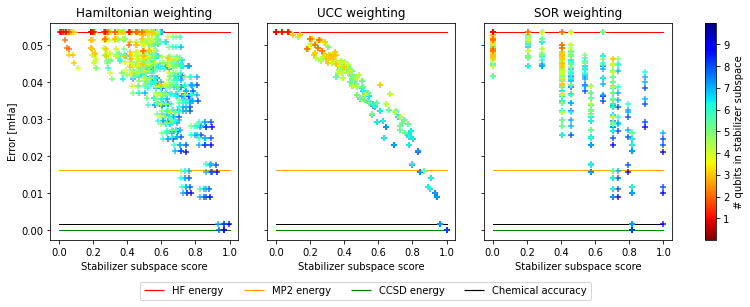

In [32]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

fig,axes = plt.subplots(1,4, sharey=True, sharex=True, 
                        gridspec_kw={'width_ratios': [10, 10, 10, 1]}, figsize=(12,4))
increments = []

def plot_data(X, axis_ind):
    axes[axis_ind].scatter(
        X, Y, 
        marker='+', 
        color=c, 
        #label = f'{ham_tap.n_qubits - stab_ind}-qubit CS-VQE', 
        zorder=stab_ind,
        alpha=0.9
    )
    axes[axis_ind].set_xlabel('Stabilizer subspace score')
    axes[axis_ind].hlines(hf_energy-fci_energy, 0, 1, ls='-', lw=1, color='red', zorder=0)
    axes[axis_ind].hlines(mp2_energy-fci_energy, 0, 1, ls='-', lw=1, color='orange', zorder=0)
    axes[axis_ind].hlines(ccsd_energy-fci_energy, 0, 1, ls='-', lw=1, color='green', zorder=0)
    axes[axis_ind].hlines(0.0016, 0, 1, ls='-', lw=1, color='black', zorder=0)

for stab_ind, data in cs_data.items():
    c_ratio = stab_ind/ham_tap.n_qubits
    increments.append(c_ratio)
    c = plt.cm.jet(c_ratio)
    X_ham, X_ucc, X_sor, Y = zip(*data)
    X_avg = [(a+b+c)/3 for a,b,c in zip(X_ham, X_ucc, X_sor)]
    X_hyb = [(a*b*c)   for a,b,c in zip(X_ham, X_ucc, X_sor)]
    Y = np.array(Y)
    Y-=fci_energy

    plot_data(X_ham, 0)
    plot_data(X_ucc, 1)
    plot_data(X_sor, 2)
    
axes[0].set_ylabel('Error [mHa]')
axes[0].set_title('Hamiltonian weighting')
axes[1].set_title('UCC weighting')
axes[2].set_title('SOR weighting')

keys = list(cs_data.keys())
cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap='jet_r'), 
                     ax=axes[3], label='# qubits in stabilizer subspace', ticks=increments, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axes[3].hlines(hf_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='red', label='HF energy', zorder=0)
axes[3].hlines(mp2_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='orange', label='MP2 energy', zorder=0)
axes[3].hlines(ccsd_energy-fci_energy, 0, 0, ls='-', lw=1.2, color='green', label='CCSD energy', zorder=0)
axes[3].hlines(0.0016, 0, 0, ls='-', lw=1.2, color='black', label='Chemical accuracy', zorder=0)
    
axes[3].set_visible(False)    
    
fig.legend(loc="lower center", bbox_to_anchor=(.49,-.1), ncol=4)

In [33]:
fig.savefig('plots/'+speciesname+'_stab_score_vs_error.png', dpi=300, bbox_inches='tight')

In [34]:
#obsrv = ObservableOp(ham_tap.symp_matrix, ham_tap.coeff_vec)
#ansatz = AnsatzOp(ucc_tap.symp_matrix, ucc_tap.coeff_vec)

In [35]:
#obsrv.ansatz_expectation(ansatz, hf_tapered)